参考: https://qiita.com/sugulu_Ogawa_ISID/items/697bd03499c1de9cf082

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader

print(torch.__version__)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

e:\anaconda_env\nlp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.11.0+cu113


device(type='cuda')

In [2]:
train_df = pd.read_csv("train_eval.tsv", sep="\t",  names=('text', 'label'))
test_df = pd.read_csv("test.tsv", sep="\t",  names=('text', 'label'))

test_df.head

<bound method NDFrame.head of                                                    text  label
0     Peachyでも大人気の「恋愛」をテーマにした記事の週間ランキングです！2012年6月21日...      5
1     値下げや利用可能国が拡大！テレコムスクエアは1日、ポストペイドタイプの海外向けSIMカード「...      6
2     ４月。新しい年度を迎え、新しい顧客の開拓、新しい取引先、新しい上司や同僚。エネルギーに満ち溢...      3
3     Xperia GXが発表！ソニーモバイルコミュニケーションズは9日、国内向けとして2012年...      6
4     1月も後半に入り、バレンタインデーの話題も増えてきた今日この頃。皆さんはチョコを贈る相手、決...      5
...                                                 ...    ...
1470  今週末26日、さいたまスーパーアリーナで開催される世界最高峰の総合格闘技イベント＝UFC日本...      7
1471  名番組「突撃！隣の晩ごはん」のヨネスケが、今度は「OLの昼ごはん」をレポートする。華やかな企...      0
1472  新年度を迎え、周りの環境も変わると、職場や取引先でも新しい出会いが増えるこの季節。名刺交換中...      5
1473  5日深夜、アルガルベカップで、宿敵アメリカ代表からはじめて勝利を挙げたサッカー女子日本代表＝...      7
1474  「男子厨房に入らず」—。「弁当男子」なんて言葉も登場している現代では、死語と言えるだろう。で...      0

[1475 rows x 2 columns]>

In [3]:
# データのカウント
label_list = train_df["label"].unique()
train_df["label"].value_counts() + test_df["label"].value_counts()


0    871
1    871
2    865
3    512
4    871
5    843
6    871
7    901
8    771
Name: label, dtype: int64

In [4]:
train_df, valid_df = train_test_split(train_df, test_size=0.2, shuffle=False)

In [5]:
import torch
from transformers import AdamW, AutoTokenizer, AutoModelForMaskedLM, AutoModelForSequenceClassification
from transformers import ElectraTokenizer, ElectraForSequenceClassification
# model_path = "cl-tohoku/bert-base-japanese"
model_path = "transformers-ud-japanese-electra-base-discriminator"
# model_path = "izumi-lab/electra-small-japanese-fin-discriminator"


In [6]:
tokenizer = ElectraTokenizer.from_pretrained(model_path)
model = ElectraForSequenceClassification.from_pretrained(model_path, num_labels=len(label_list))
model

OSError: transformers-ud-japanese-electra-base-discriminator is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo with `use_auth_token` or log in with `huggingface-cli login` and pass `use_auth_token=True`.

In [ ]:
max_len = 100
train_encoding = tokenizer(train_df["text"].to_list(), return_tensors="pt",padding=True, truncation=True, max_length=max_len)
valid_encoding = tokenizer(valid_df["text"].to_list(), return_tensors="pt",padding=True, truncation=True, max_length=max_len)
test_encoding = tokenizer(test_df["text"].to_list(), return_tensors="pt",padding=True, truncation=True, max_length=max_len)

In [ ]:
train_label = torch.tensor(train_df["label"].to_list())
valid_label = torch.tensor(valid_df["label"].to_list())
test_label = torch.tensor(test_df["label"].to_list())

In [ ]:
# 0 番目 の 5 トーク ン までの ID を 表示
print(train_encoding["input_ids"][ 0][: 5]) 
# 0 番目 の 5 トーク ン までの トー クン を デコード し て 表示
print(tokenizer.decode(train_encoding["input_ids"][0][:5]))

tensor([    1, 28677,  6774, 18608, 10832])
[CLS] 転職者なら誰


In [ ]:
class CreateDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__( self, idx):
        item = {key:torch.tensor(val[idx]).clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).clone().detach()
        return item
    
    def __len__( self):
        return len(self.labels)

train_dataset = CreateDataset(train_encoding, train_label)
val_dataset = CreateDataset(valid_encoding, valid_label)
test_dataset = CreateDataset(test_encoding, test_label)


In [ ]:
for i in train_dataset:
    print(i.keys())
    print(i)
    break

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
{'input_ids': tensor([    1, 28677,  6774, 18608, 10832, 14004, 18265, 13372,  8198,  6572,
        11900,  7366,  6271,  7145,  6983,   669, 11927,   668, 12486,  6371,
         6401,  6619,  8307,  6932,  6774, 13104,  6821,  7078,  6274,  7223,
         6246,  6386,  6232, 24591,  6305, 17761, 17761,  6267,  6246, 14409,
        14451,   669, 13585,  6265,  6271, 14970, 12014, 26449,   668, 11930,
         6271,  8083,  8971,  6774,  6274,  6839,  6276,  6246,  6185,  6401,
         6619,  8307,  6932,  6774,  6371,   668, 29106,  6182,   588, 12306,
        22131,   589,   756,  7145,  6371,  9025,  6181,  8198,  6572,  6213,
         6338, 14591,  6182,  6266,  6274,  6265,  6184, 29369,  7269, 20734,
         6221,  6185, 18934,  6185,   669,   677, 17279,  6271,  6224,     2]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 

C:\Users\windo\AppData\Local\Temp\ipykernel_30492\1214768838.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]).clone().detach() for key, val in self.encodings.items()}
C:\Users\windo\AppData\Local\Temp\ipykernel_30492\1214768838.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx]).clone().detach()


In [ ]:
def saveModel(): 
    path = "./XLnetModel.pth" 
    torch.save(model.state_dict(), path)

model = model.to(device)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
validate_loader = DataLoader(val_dataset, batch_size = 16, shuffle = True)

optimizer = AdamW(model.parameters(), lr=0.005)
model.train()
epochs = 50
train_losses = []
valid_losses = []
acc_epoc = []
best_accuracy = 0.0 

model.train()
#再学習
for epoch in range(epochs):
    running_train_loss = 0.0 
    running_accuracy = 0.0 
    running_vall_loss = 0.0 
    total = 0 

    # Training Loop 
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask = attention_mask, labels = labels)
        logits = outputs.logits
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        running_train_loss +=loss.item()

    # Calculate training loss value 
    train_loss_value = running_train_loss/len(train_loader) 
    train_losses.append(train_loss_value)
    
    # Validation Loop 
    with torch.no_grad(): 
        model.eval() 
        for batch in tqdm(validate_loader): 
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask = attention_mask, labels = labels)
            logits = outputs.logits
            val_loss = outputs.loss
            
            
            # The label with the highest value will be our prediction 
            _, predicted = torch.max(logits, 1) 
            running_vall_loss += val_loss.item()  
            total += logits.size(0) 
            running_accuracy += (predicted == labels).sum().item()

    # Calculate validation loss value 
    val_loss_value = running_vall_loss/len(validate_loader)
    valid_losses.append(val_loss_value)
            
    # Calculate accuracy as the number of correct predictions in the validation batch divided by the total number of predictions done.  
    accuracy = (100 * running_accuracy / total)
    acc_epoc.append(accuracy)    

    # Save the model if the accuracy is the best 
    if accuracy > best_accuracy: 
        saveModel() 
        best_accuracy = accuracy

    print('Completed training batch', epoch, 'Training Loss is: %.4f' %train_loss_value, 'Validation Loss is: %.4f' %val_loss_value, 'Accuracy is %d %%' % (accuracy))

  0%|          | 0/295 [00:00<?, ?it/s]C:\Users\windo\AppData\Local\Temp\ipykernel_30492\1214768838.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]).clone().detach() for key, val in self.encodings.items()}
C:\Users\windo\AppData\Local\Temp\ipykernel_30492\1214768838.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx]).clone().detach()
100%|██████████| 74/74 [00:07<00:00, 10.49it/s]


Completed training batch 0 Training Loss is: 2.1892 Validation Loss is: 2.1880 Accuracy is 11 %


100%|██████████| 74/74 [00:07<00:00, 10.50it/s]


Completed training batch 1 Training Loss is: 2.1865 Validation Loss is: 2.1880 Accuracy is 11 %


100%|██████████| 74/74 [00:07<00:00, 10.49it/s]


Completed training batch 2 Training Loss is: 2.1870 Validation Loss is: 2.1874 Accuracy is 11 %


100%|██████████| 74/74 [00:07<00:00, 10.50it/s]


Completed training batch 3 Training Loss is: 2.1868 Validation Loss is: 2.1873 Accuracy is 11 %


100%|██████████| 74/74 [00:07<00:00, 10.47it/s]


Completed training batch 4 Training Loss is: 2.1866 Validation Loss is: 2.1880 Accuracy is 11 %


100%|██████████| 74/74 [00:06<00:00, 10.71it/s]


Completed training batch 5 Training Loss is: 2.1868 Validation Loss is: 2.1879 Accuracy is 11 %


100%|██████████| 74/74 [00:06<00:00, 10.70it/s]


Completed training batch 6 Training Loss is: 2.1869 Validation Loss is: 2.1883 Accuracy is 11 %


100%|██████████| 74/74 [00:06<00:00, 10.71it/s]


Completed training batch 7 Training Loss is: 2.1866 Validation Loss is: 2.1874 Accuracy is 11 %


100%|██████████| 74/74 [00:06<00:00, 10.74it/s]


Completed training batch 8 Training Loss is: 2.1867 Validation Loss is: 2.1871 Accuracy is 11 %


100%|██████████| 74/74 [00:07<00:00, 10.45it/s]


Completed training batch 9 Training Loss is: 2.1868 Validation Loss is: 2.1869 Accuracy is 11 %


100%|██████████| 74/74 [00:07<00:00, 10.46it/s]


Completed training batch 10 Training Loss is: 2.1866 Validation Loss is: 2.1873 Accuracy is 11 %


100%|██████████| 74/74 [00:07<00:00, 10.44it/s]


Completed training batch 11 Training Loss is: 2.1869 Validation Loss is: 2.1873 Accuracy is 11 %


100%|██████████| 74/74 [00:07<00:00, 10.44it/s]


Completed training batch 12 Training Loss is: 2.1869 Validation Loss is: 2.1874 Accuracy is 11 %


100%|██████████| 74/74 [00:07<00:00, 10.45it/s]


Completed training batch 13 Training Loss is: 2.1868 Validation Loss is: 2.1882 Accuracy is 11 %


100%|██████████| 74/74 [00:07<00:00, 10.46it/s]


Completed training batch 14 Training Loss is: 2.1868 Validation Loss is: 2.1872 Accuracy is 11 %


100%|██████████| 74/74 [00:07<00:00, 10.44it/s]


Completed training batch 15 Training Loss is: 2.1869 Validation Loss is: 2.1875 Accuracy is 11 %


100%|██████████| 74/74 [00:07<00:00, 10.45it/s]


Completed training batch 16 Training Loss is: 2.1866 Validation Loss is: 2.1883 Accuracy is 11 %


100%|██████████| 74/74 [00:07<00:00, 10.46it/s]


Completed training batch 17 Training Loss is: 2.1868 Validation Loss is: 2.1876 Accuracy is 11 %


100%|██████████| 74/74 [00:07<00:00, 10.43it/s]


Completed training batch 18 Training Loss is: 2.1870 Validation Loss is: 2.1868 Accuracy is 11 %


100%|██████████| 74/74 [00:06<00:00, 10.65it/s]


Completed training batch 19 Training Loss is: 2.1867 Validation Loss is: 2.1884 Accuracy is 11 %


100%|██████████| 74/74 [00:06<00:00, 10.67it/s]


Completed training batch 20 Training Loss is: 2.1868 Validation Loss is: 2.1868 Accuracy is 11 %


100%|██████████| 74/74 [00:06<00:00, 10.63it/s]


Completed training batch 21 Training Loss is: 2.1868 Validation Loss is: 2.1877 Accuracy is 11 %


100%|██████████| 74/74 [00:06<00:00, 10.66it/s]


Completed training batch 22 Training Loss is: 2.1865 Validation Loss is: 2.1869 Accuracy is 11 %


100%|██████████| 74/74 [00:07<00:00, 10.42it/s]


Completed training batch 23 Training Loss is: 2.1866 Validation Loss is: 2.1883 Accuracy is 11 %


100%|██████████| 74/74 [00:07<00:00, 10.41it/s]


Completed training batch 24 Training Loss is: 2.1869 Validation Loss is: 2.1875 Accuracy is 11 %


100%|██████████| 74/74 [00:07<00:00, 10.38it/s]


Completed training batch 25 Training Loss is: 2.1865 Validation Loss is: 2.1888 Accuracy is 11 %


100%|██████████| 74/74 [00:07<00:00, 10.40it/s]


Completed training batch 26 Training Loss is: 2.1869 Validation Loss is: 2.1876 Accuracy is 11 %


100%|██████████| 74/74 [00:07<00:00, 10.41it/s]


Completed training batch 27 Training Loss is: 2.1868 Validation Loss is: 2.1876 Accuracy is 11 %


100%|██████████| 74/74 [00:07<00:00, 10.39it/s]


Completed training batch 28 Training Loss is: 2.1867 Validation Loss is: 2.1869 Accuracy is 11 %


100%|██████████| 74/74 [00:07<00:00, 10.40it/s]


Completed training batch 29 Training Loss is: 2.1867 Validation Loss is: 2.1889 Accuracy is 11 %


100%|██████████| 74/74 [00:07<00:00, 10.40it/s]


Completed training batch 30 Training Loss is: 2.1869 Validation Loss is: 2.1873 Accuracy is 11 %


100%|██████████| 74/74 [00:07<00:00, 10.39it/s]


Completed training batch 31 Training Loss is: 2.1869 Validation Loss is: 2.1869 Accuracy is 11 %


100%|██████████| 74/74 [00:07<00:00, 10.39it/s]


Completed training batch 32 Training Loss is: 2.1868 Validation Loss is: 2.1879 Accuracy is 11 %


100%|██████████| 74/74 [00:07<00:00, 10.39it/s]


Completed training batch 33 Training Loss is: 2.1867 Validation Loss is: 2.1879 Accuracy is 11 %


100%|██████████| 74/74 [00:06<00:00, 10.60it/s]


Completed training batch 34 Training Loss is: 2.1868 Validation Loss is: 2.1873 Accuracy is 11 %


100%|██████████| 74/74 [00:06<00:00, 10.64it/s]


Completed training batch 35 Training Loss is: 2.1868 Validation Loss is: 2.1875 Accuracy is 11 %


100%|██████████| 74/74 [00:06<00:00, 10.61it/s]


Completed training batch 36 Training Loss is: 2.1869 Validation Loss is: 2.1881 Accuracy is 11 %


100%|██████████| 74/74 [00:06<00:00, 10.66it/s]


Completed training batch 37 Training Loss is: 2.1866 Validation Loss is: 2.1881 Accuracy is 11 %


100%|██████████| 74/74 [00:06<00:00, 10.66it/s]


Completed training batch 38 Training Loss is: 2.1867 Validation Loss is: 2.1874 Accuracy is 11 %


100%|██████████| 74/74 [00:06<00:00, 10.64it/s]


Completed training batch 39 Training Loss is: 2.1869 Validation Loss is: 2.1878 Accuracy is 11 %


100%|██████████| 74/74 [00:06<00:00, 10.59it/s]


Completed training batch 40 Training Loss is: 2.1868 Validation Loss is: 2.1881 Accuracy is 11 %


100%|██████████| 74/74 [00:06<00:00, 10.59it/s]


Completed training batch 41 Training Loss is: 2.1869 Validation Loss is: 2.1876 Accuracy is 11 %


100%|██████████| 74/74 [00:06<00:00, 10.63it/s]


Completed training batch 42 Training Loss is: 2.1865 Validation Loss is: 2.1871 Accuracy is 11 %


100%|██████████| 74/74 [00:06<00:00, 10.62it/s]


Completed training batch 43 Training Loss is: 2.1868 Validation Loss is: 2.1875 Accuracy is 11 %


100%|██████████| 74/74 [00:06<00:00, 10.62it/s]


Completed training batch 44 Training Loss is: 2.1867 Validation Loss is: 2.1877 Accuracy is 11 %


100%|██████████| 74/74 [00:07<00:00, 10.54it/s]


Completed training batch 45 Training Loss is: 2.1866 Validation Loss is: 2.1865 Accuracy is 12 %


100%|██████████| 74/74 [00:06<00:00, 10.66it/s]


Completed training batch 46 Training Loss is: 2.1869 Validation Loss is: 2.1882 Accuracy is 11 %


100%|██████████| 74/74 [00:06<00:00, 10.67it/s]


Completed training batch 47 Training Loss is: 2.1867 Validation Loss is: 2.1874 Accuracy is 12 %


100%|██████████| 74/74 [00:07<00:00, 10.38it/s]


Completed training batch 48 Training Loss is: 2.1869 Validation Loss is: 2.1873 Accuracy is 11 %


100%|██████████| 74/74 [00:06<00:00, 10.62it/s]

Completed training batch 49 Training Loss is: 2.1868 Validation Loss is: 2.1879 Accuracy is 11 %


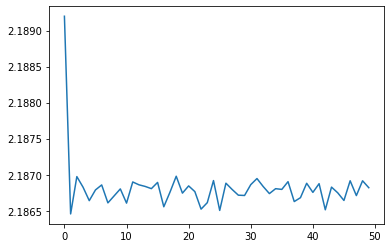

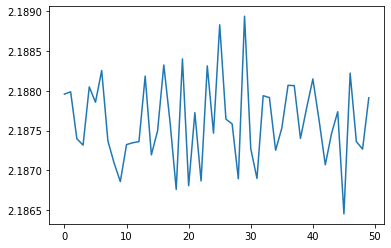

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
losses_ = [loss for loss in train_losses]
plt.plot(losses_)
plt.show()

losses_ = [loss for loss in valid_losses]
plt.plot(losses_)
plt.show()

In [ ]:
model.eval()
preds = []
test_label = test_df["label"].to_list()
with torch.no_grad():
    for words in tqdm(test_df["text"].to_list()):
        text = "".join(words)
        inputs = tokenizer.encode(text, return_tensors="pt",padding=True, truncation=True, max_length=max_len).to(device)
        outputs = model(inputs)
        logits = outputs.logits
        pred=logits.argmax(1).item()
        preds.append(pred)

100%|██████████| 1475/1475 [00:30<00:00, 49.07it/s]


In [ ]:
correct_cnt = 0
for pred, ans in zip(preds, test_label):
    if pred == ans:
        correct_cnt += 1 # 正解 率（ ＝ 全 データ の うち 正解 が どれ だけか)
print( correct_cnt/ len(test_label))

0.12542372881355932


カテゴリー数: 9
['dokujo-tsushin', 'it-life-hack', 'kaden-channel', 'livedoor-homme', 'movie-enter', 'peachy', 'smax', 'sports-watch', 'topic-news']


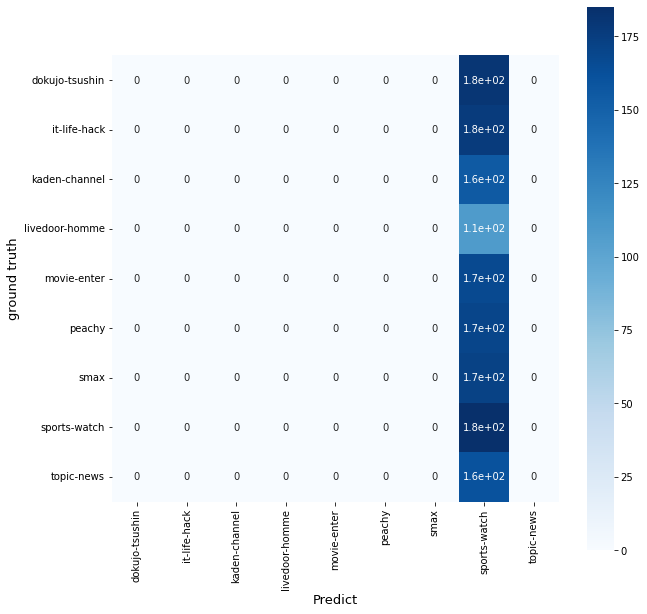

In [ ]:
from sklearn.metrics import confusion_matrix

categories = [name for name in os.listdir(
    "./data/livedoor/text/") if os.path.isdir("./data/livedoor/text/"+name)]

print("カテゴリー数:", len(categories))
print(categories)

cm = confusion_matrix(test_label, preds)
cm = pd.DataFrame(data=cm, index=categories, 
                           columns=categories,)

fig = plt.figure()
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
plt.yticks(rotation=0)
plt.xlabel("Predict", fontsize=13, rotation=0)
plt.ylabel("ground truth", fontsize=13)
fig.set_figheight(10)
fig.set_figwidth(10)